# Customer Churn Prediction with PySpark

Detect and predict customer churn with machine learning models is a common problem Data Scientists are often confronted with in a customer-facing business. This project will serve as an exploration of how to make a churn-prediction model using PySpark, with the following steps included:
* explore and manipulate our dataset
* engineer relevant features for our problem
* split data into train and test sets by sampling churn
* train binary classifier models with Spark’s DataFrame-based MLlib
* select and fine-tune the final model with Spark’s ML Pipelines and a StratifiedCrossValidator
* Evaluation of Prediction Performance (Metric: F1 Score)

In Part I we only use a subset of data (128MB) to train our churn prediction models locally with Spark. In order to use the full dataset (12GB) for model training, check the Part II, where we deploy a cluster on a cloud service.

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.8 MB 41 kB/s s eta 0:00:01  |█▍                              | 8.9 MB 2.9 MB/s eta 0:01:07
     |████████████████████████████████| 198 kB 42.6 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186687 sha256=0b024e7304a6be2564a51624f82290db82d4f2d672318f5bc68d1f93cdbcbe4d
  Stored in directory: /root/.cache/pip/wheels/9a/39/f6/970565f38054a830e9a8593f388b36e14d75dba6c6fdafc1ec
Successfully built pyspark


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml import feature as FT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# set up a Spark session
spark = SparkSession \
        .builder \
        .appName('Sparkify Churn Prediction') \
        .getOrCreate()

In [4]:
# Check, if Spark session was setup correctly
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1614325711922'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1614325713212'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '9e1de31ea5ed'),
 ('spark.app.name', 'Sparkify Churn Prediction'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '45097')]

# About the Dataset
We will use the user events logs (duration about 2 months) of a music-streaming service called Sparkify as our dataset. The dataset contains 286,500 rows and 18 features. With these logs we can predict whether this user is more likely to stay or is more likely to churn.

[dataset screen here]

* artist: singer of a song
* auth: login status
* firstName: first name of the user
* gender: gender of the user
* itemInSession: number of the item in the current session
* lastName: surname of the user
* length: song length
* level: whether a customer is paying for the service or not
* location: location of the user
* method: how a user is getting web pages
* page: page browsing information
* registration: time stamp of the regestration of the user
* sessionId: session ID
* song: name of a song
* status: page return code
* ts: timestamp of the log item
* userAgent: browser client
* userId: user ID

# Load/Clean/Transform Data

In [5]:
# Load dataset
df = spark.read.json('../input/mini-sparkify/mini_sparkify_event_data.json')

In [6]:
# show number of rows
df.count()

286500

In [7]:
# show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# show first rows
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
# check missing (NaN) values in all columns
count_nan_cols = [F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]
df.select(count_nan_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* No missing(NaN) values in all columns.

In [10]:
# check Null values in all columns
count_null_cols = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]
df.select(count_null_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


* Null values are found in columns related with user information and song information.

In [11]:
df.filter(F.col('artist').isNull()).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [12]:
df.filter(F.col('artist').isNull()!=True).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


* Pages that are not NextSong will have null values for artist, length and song.

In [13]:
# check empty columns per column
count_invalid_cols = [F.count(F.when(F.col(c)=='', c)).alias(c) for c in df.columns]
df.select(count_invalid_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


In [14]:
# check out rows with empty userId 
df.filter(F.col('userId')=='').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


* Users with empty userId are those who did not register and log in.

In [15]:
# drop rows with missing user id
df = df.where(df.userId!='')

# drop duplicate rows if any exists
df = df.dropDuplicates()

df.count()

278154

In [16]:
# convert Timestamps (ts) to Datetime
df = df.withColumn('reg_date', (F.col('registration')/1000).cast(T.TimestampType()))
df = df.withColumn('date', (F.col('ts')/1000).cast(T.TimestampType()))

In [17]:
churned_users = df.filter(F.col('page')=='Cancellation Confirmation')

flag_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())
df = df.withColumn('churn', flag_churn('page'))

churned_users.count()

52

# Exploratory Data Analysis

In [18]:
# user-based observation start/end dates
min_date = df.agg({'date':'min'}).collect()[0]['min(date)']
max_date = df.agg({'date':'max'}).collect()[0]['max(date)']
min_reg_date = df.agg({'reg_date':'min'}).collect()[0]['min(reg_date)']
max_reg_date = df.agg({'reg_date':'max'}).collect()[0]['max(reg_date)']

print(f'min_date:{min_date}')
print(f'max_date:{max_date}')
print(f'min_reg_date:{min_reg_date}')
print(f'max_reg_date:{max_reg_date}')

min_date:2018-10-01 00:01:57
max_date:2018-12-03 01:11:16
min_reg_date:2018-03-18 13:44:35
max_reg_date:2018-11-26 15:49:14


In [19]:
# get first log date
w = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('first_date', F.first('date').over(w))

# infer observation start date
df = df.withColumn('obs_start',
                  (F.when(F.col('reg_date')<min_date, min_date)
                    .when(F.col('reg_date')<F.col('first_date'), F.col('reg_date'))
                    .otherwise(F.col('first_date')))
                  )

# infer observation end date
df = df.withColumn('obs_end',
                  (F.when(F.last('churn').over(w)==1, F.last('date').over(w))
                     .otherwise(max_date))
                  )

In [20]:
# last subscription level
df = df.withColumn('last_level', F.last('level').over(w))

In [21]:
# get day, weekdady out of the date
df = df.withColumn('hour', F.date_format(F.col('date'), 'H'))
df = df.withColumn('weekday', F.date_format(F.col('date'), 'E'))

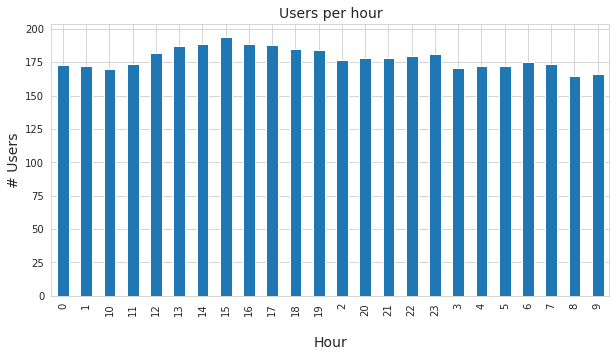

In [22]:
# user distribution per hour of the day
users_per_hour_pd = df.select(['userId', 'hour']).dropDuplicates().groupBy(['hour']).count().sort('hour').toPandas()

# observe the distribution
ax = users_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Users', fontsize=14)
plt.title('Users per hour', fontsize=14)
plt.show()

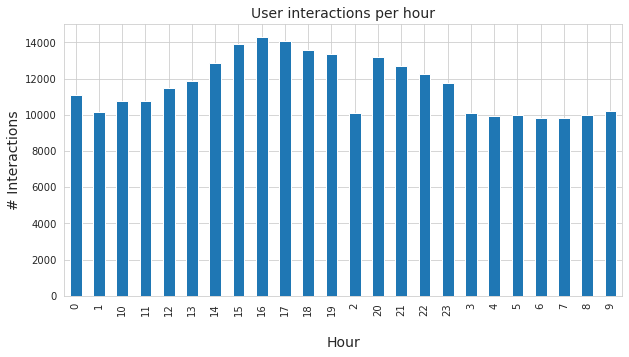

In [23]:
# user interaction per hour
interactions_per_hour_pd = df.select(['userId', 'hour']).groupBy(['hour']).count().sort('hour').toPandas()

# plot the interactoins
ax = interactions_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per hour', fontsize=14)
plt.show()

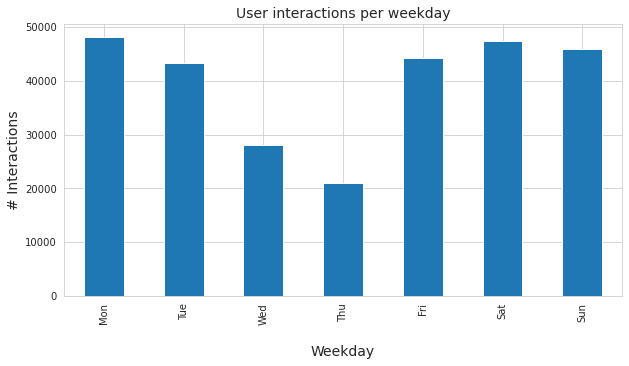

In [24]:
# user interactions per weekday
interactions_per_weekday_pd = df.select(['userId', 'weekday']).groupBy(['weekday']).count().sort('weekday').toPandas()

# Plot
ax = interactions_per_weekday_pd.plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nWeekday', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per weekday', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

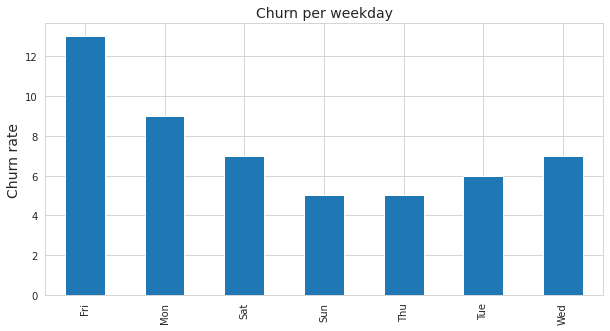

In [25]:
# churn per weekday
churn_per_weekday_pd = df.select(['userId', 'weekday', 'churn']).groupby(['weekday']).sum().sort('weekday').toPandas()

# Plot
ax = churn_per_weekday_pd[['weekday','sum(churn)']].plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('', fontsize=14)
plt.ylabel('Churn rate', fontsize=14)
plt.title('Churn per weekday', fontsize=14)
plt.show()

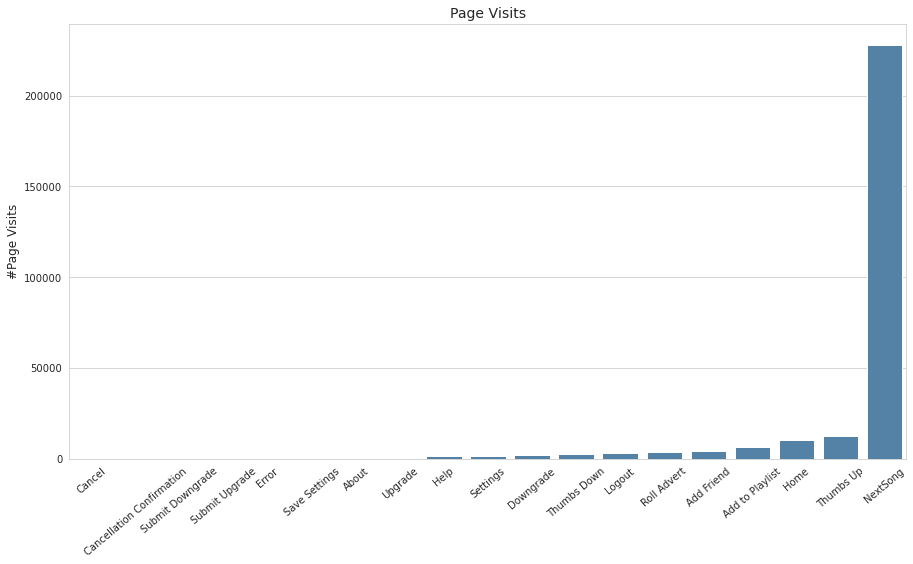

In [26]:
# number ofr page visits
page_visits_pd = df.groupBy('page').count().toPandas().sort_values('count')

# plot all page events in the dataset:
plt.figure(figsize=(15,8))
sns.barplot(x='page', y='count', data=page_visits_pd, color='steelblue')
plt.title('Page Visits', fontsize=14)
plt.xticks(rotation=40)
plt.xlabel('', fontsize=12)
plt.ylabel('#Page Visits', fontsize=12)
plt.show();

# Feature Engineering

![](http://)Now that we've familiarized ourselves with the data set, we try to find and build promising features to train the model on.

In [27]:
# aggregation by user
user_df = df.groupby('userId').agg(
    
    # User-level features
    F.max('churn').alias('churn'),
    F.first('gender').alias('gender'),
    F.first('reg_date').alias('reg_date'),
    F.first('obs_start').alias('obs_start'),
    F.first('obs_end').alias('obs_end'),
    F.first('last_level').alias('last_level'),
    
    # interaction-level features (exclude Cancellation Confirmation)
    F.count('page').alias('n_act'),
    F.sum(F.when(F.col('page')=='About', 1).otherwise(0)).alias('n_about'),
    F.sum(F.when(F.col('page')=='Add Friend', 1).otherwise(0)).alias('n_addFriend'),
    F.sum(F.when(F.col('page')=='Add to Playlist', 1).otherwise(0)).alias('n_addToPlaylist'),
    F.sum(F.when(F.col('page')=='Cancel', 1).otherwise(0)).alias('n_cancel'),
    F.sum(F.when(F.col('page')=='Downgrade', 1).otherwise(0)).alias('n_downgrade'),
    F.sum(F.when(F.col('page')=='Error', 1).otherwise(0)).alias('n_error'),
    F.sum(F.when(F.col('page')=='Help', 1).otherwise(0)).alias('n_help'),
    F.sum(F.when(F.col('page')=='Home', 1).otherwise(0)).alias('n_home'),
    F.sum(F.when(F.col('page')=='Logout', 1).otherwise(0)).alias('n_logout'),
    F.sum(F.when(F.col('page')=='NextSong', 1).otherwise(0)).alias('n_song'),
    F.sum(F.when(F.col('page')=='Roll Advert', 1).otherwise(0)).alias('n_rollAdvert'),
    F.sum(F.when(F.col('page')=='Save Settings', 1).otherwise(0)).alias('n_saveSettings'),
    F.sum(F.when(F.col('page')=='Settings', 1).otherwise(0)).alias('n_settings'),
    F.sum(F.when(F.col('page')=='Submit Downgrade', 1).otherwise(0)).alias('n_submitDowngrade'),
    F.sum(F.when(F.col('page')=='Submit Upgrade', 1).otherwise(0)).alias('n_submitUpgrade'),
    F.sum(F.when(F.col('page')=='Thumbs Down', 1).otherwise(0)).alias('n_thumbsDown'),
    F.sum(F.when(F.col('page')=='Thumbs Up', 1).otherwise(0)).alias('n_thumbsUp'),
    F.sum(F.when(F.col('page')=='Upgrade', 1).otherwise(0)).alias('n_upgrade'),
    
    # song-level features
    F.countDistinct('artist').alias('n_artist'),
    F.sum('length').alias('sum_length'),
    
    # session-level features
    F.countDistinct('sessionId').alias('n_session'),
)

In [28]:
# extract new features from some aggregated statistics
user_df = (user_df.withColumn('reg_days', F.datediff('obs_end', 'reg_date'))
                  .withColumn('obs_hours', (F.unix_timestamp('obs_end')-F.unix_timestamp('obs_start'))/3600)
                  .withColumn('n_act_per_hour', F.col('n_act')/F.col('obs_hours'))
                  .withColumn('n_about_per_hour', F.col('n_about')/F.col('obs_hours'))
                  .withColumn('n_addFriend_per_hour', F.col('n_addFriend')/F.col('obs_hours'))
                  .withColumn('n_addToPlaylist_per_hour', F.col('n_addToPlaylist')/F.col('obs_hours'))
                  .withColumn('n_downgrade_per_hour', F.col('n_downgrade')/F.col('obs_hours'))
                  .withColumn('n_error_per_hour', F.col('n_error')/F.col('obs_hours'))
                  .withColumn('n_help_per_hour', F.col('n_help')/F.col('obs_hours'))
                  .withColumn('n_home_per_hour', F.col('n_home')/F.col('obs_hours'))
                  .withColumn('n_logout_per_hour', F.col('n_logout')/F.col('obs_hours'))
                  .withColumn('n_song_per_hour', F.col('n_song')/F.col('obs_hours'))
                  .withColumn('n_rollAdvert_per_hour', F.col('n_rollAdvert')/F.col('obs_hours'))
                  .withColumn('n_saveSettings_per_hour', F.col('n_saveSettings')/F.col('obs_hours'))
                  .withColumn('n_settings_per_hour', F.col('n_settings')/F.col('obs_hours'))
                  .withColumn('n_submitDowngrade_per_hour', F.col('n_submitDowngrade')/F.col('obs_hours'))
                  .withColumn('n_submitUpgrade_per_hour', F.col('n_submitUpgrade')/F.col('obs_hours'))
                  .withColumn('n_thumbsDown_per_hour', F.col('n_thumbsDown')/F.col('obs_hours'))
                  .withColumn('n_thumbsUp_per_hour', F.col('n_thumbsUp')/F.col('obs_hours'))
                  .withColumn('n_upgrade_per_hour', F.col('n_upgrade')/F.col('obs_hours'))
          )

In [29]:
# only use these variables
user_df = user_df.select('userId', 'churn', 'gender', 'last_level', 'sum_length', 'n_session', 'reg_days', 'obs_hours', 
                         'n_act_per_hour', 'n_about_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour',
                         'n_cancel', 'n_downgrade_per_hour', 'n_error_per_hour', 'n_help_per_hour',
                         'n_home_per_hour', 'n_logout_per_hour', 'n_song_per_hour', 'n_rollAdvert_per_hour',
                         'n_saveSettings_per_hour', 'n_settings_per_hour', 'n_submitDowngrade_per_hour',
                         'n_submitUpgrade_per_hour', 'n_thumbsDown_per_hour', 'n_thumbsUp_per_hour', 'n_upgrade_per_hour'
                        )
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- sum_length: double (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- obs_hours: double (nullable = true)
 |-- n_act_per_hour: double (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_addFriend_per_hour: double (nullable = true)
 |-- n_addToPlaylist_per_hour: double (nullable = true)
 |-- n_cancel: long (nullable = true)
 |-- n_downgrade_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_help_per_hour: double (nullable = true)
 |-- n_home_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nul

In [30]:
# convert to pandas dataframe for easy visualization
user_pd = user_df.toPandas()
user_pd.shape

(225, 27)

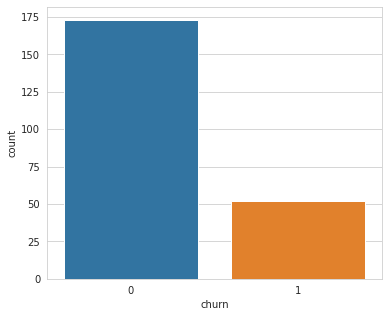

In [31]:
# observe the behavior for users who stayed vs users who churned
plt.figure(figsize=(6,5))
sns.countplot(x='churn', data=user_pd)
# plt.savefig('dist_churn.png')
plt.show();

In [32]:
# categorical columns
cat_cols = user_pd.select_dtypes('object').columns.tolist()
cat_cols.remove('userId')
cat_cols

['gender', 'last_level']

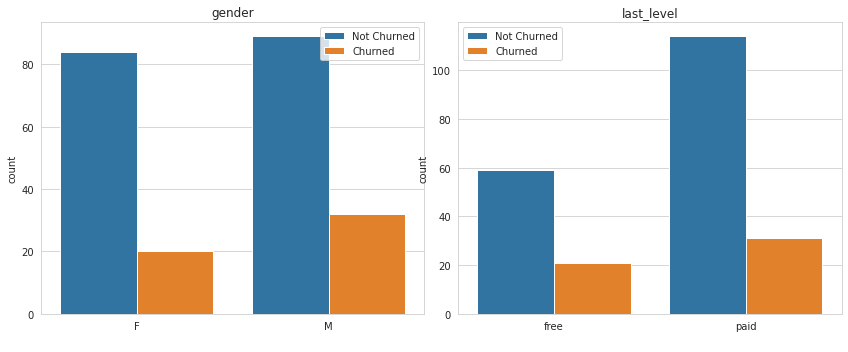

In [33]:
# observe the distribution of categorical features
plt.figure(figsize=(12,5))

for i in range(len(cat_cols)):
    plt.subplot(1, 2, i+1)
    plt.tight_layout()
    sns.countplot(x=cat_cols[i], data=user_pd, hue='churn')
    plt.legend(['Not Churned', 'Churned'])
    plt.title(cat_cols[i])
    plt.xlabel(' ')
    
# plt.savefig('dist_categorical.png')
plt.show();

In [34]:
# numerical columns
num_cols = user_pd.select_dtypes(include=np.number).columns.tolist()
num_cols

['churn',
 'sum_length',
 'n_session',
 'reg_days',
 'obs_hours',
 'n_act_per_hour',
 'n_about_per_hour',
 'n_addFriend_per_hour',
 'n_addToPlaylist_per_hour',
 'n_cancel',
 'n_downgrade_per_hour',
 'n_error_per_hour',
 'n_help_per_hour',
 'n_home_per_hour',
 'n_logout_per_hour',
 'n_song_per_hour',
 'n_rollAdvert_per_hour',
 'n_saveSettings_per_hour',
 'n_settings_per_hour',
 'n_submitDowngrade_per_hour',
 'n_submitUpgrade_per_hour',
 'n_thumbsDown_per_hour',
 'n_thumbsUp_per_hour',
 'n_upgrade_per_hour']

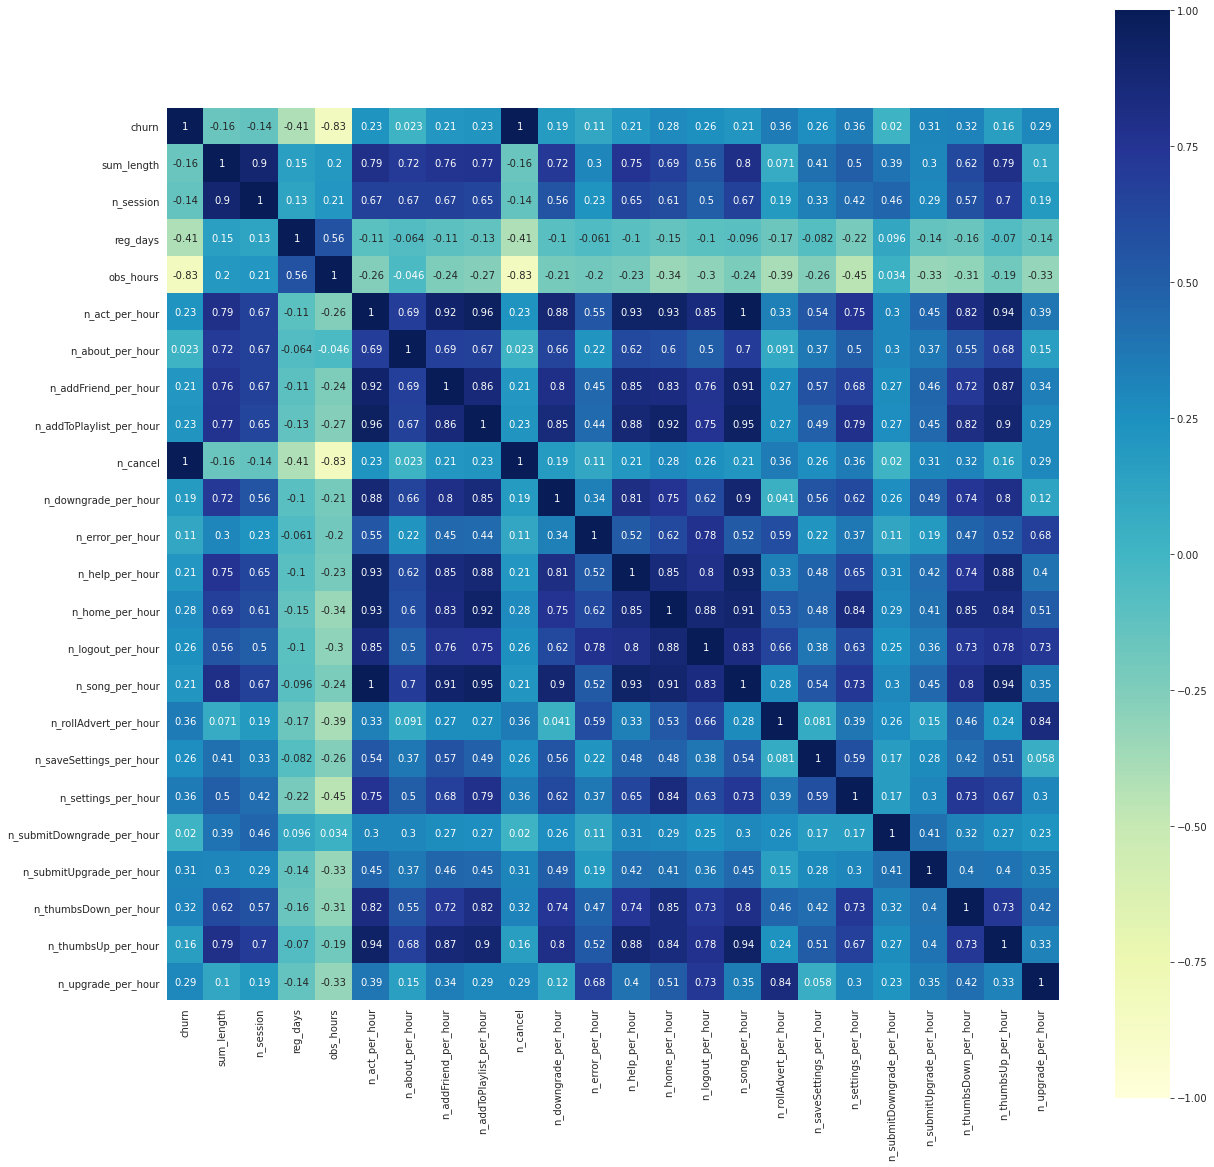

In [35]:
# a function to plot correlation among columns
def plot_corr(cols, figsize=(10, 10), filename=None, df=user_pd):
    plt.figure(figsize=figsize)
    sns.heatmap(df[cols].corr(),square=True, cmap='YlGnBu', annot=True, vmin=-1, vmax=1)
    plt.ylim(len(cols), 0)
    if filename:
        plt.savefig(filename)
    plt.show();
    
# observe the correlation between numerical features
plot_corr(num_cols, figsize=(20, 20))

Highly correlated (>0.8) variable pairs(groups):

* churn, obs_hours, n_cancel
* sum_length, n_session
* n_act_per_hour, n_addFriend_per_hour, n_addToPlaylist_per_hour, n_downgrade_per_hour, n_help_per_hour, n_home_per_hour, n_song_per_hour, n_thumbsUp_per_hour

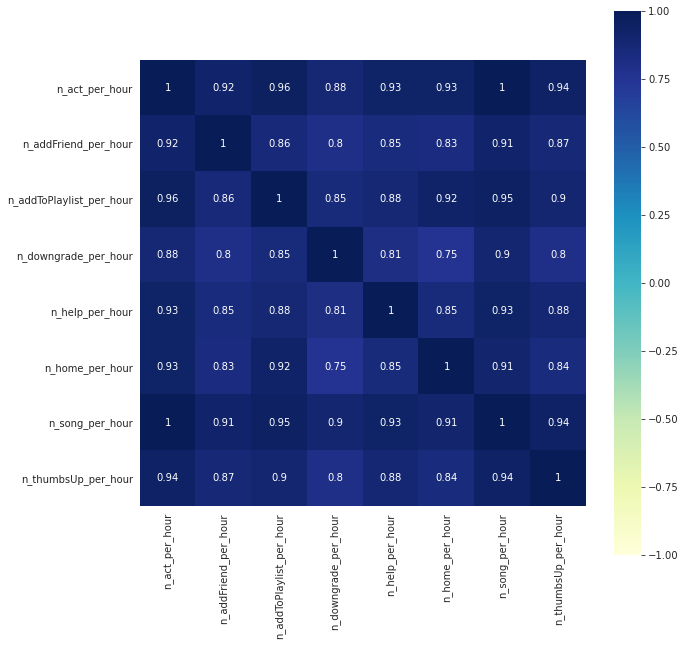

In [36]:
cols = ['n_act_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour', 'n_downgrade_per_hour',
        'n_help_per_hour', 'n_home_per_hour', 'n_song_per_hour', 'n_thumbsUp_per_hour']
plot_corr(cols)

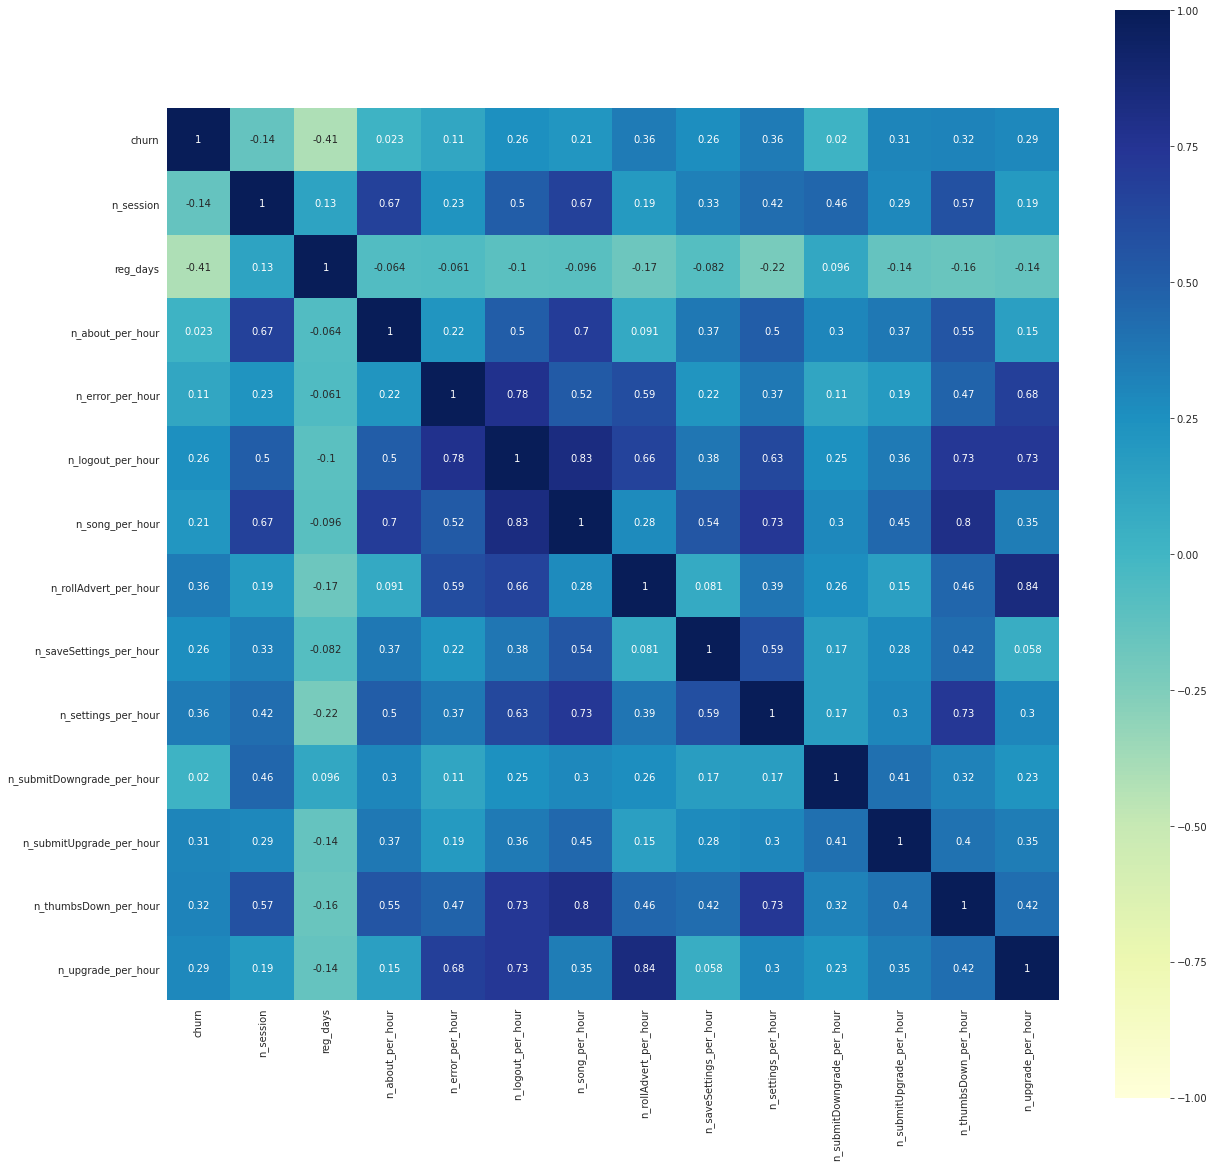

In [37]:
# highly correlated columns
drop_cols = ['obs_hours', 'n_cancel', 'sum_length', 'n_act_per_hour', 
             'n_addFriend_per_hour','n_addToPlaylist_per_hour', 
             'n_downgrade_per_hour', 'n_help_per_hour','n_home_per_hour', 
             'n_thumbsUp_per_hour']

num_cols = [col for col in num_cols if col not in drop_cols]

# observe the correlation between numerical features after removing
plot_corr(num_cols, figsize=(20, 20))

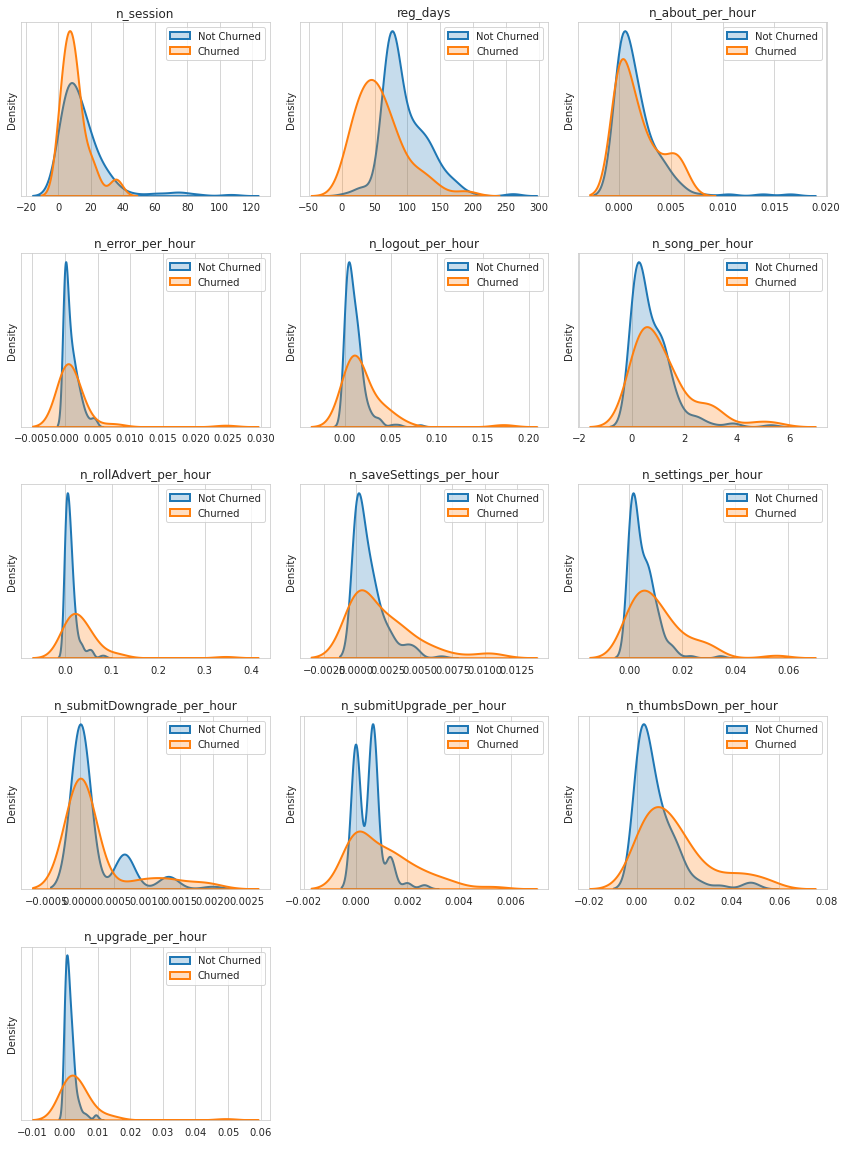

In [38]:
# observe the distribution of numerical features
num_cols.remove('churn')

plt.figure(figsize=(12, 16))

for i in range(len(num_cols)):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    sns.distplot(user_pd[user_pd['churn']==0][num_cols[i]],
                 hist=False, norm_hist=True, kde_kws={'shade': True, 'linewidth': 2})
    sns.distplot(user_pd[user_pd['churn']==1][num_cols[i]],
                 hist=False, norm_hist =True, kde_kws={'shade': True, 'linewidth': 2})
    plt.legend(['Not Churned','Churned'])
    plt.title(num_cols[i])
    plt.xlabel(' ')
    plt.yticks([])

# plt.savefig('dist_numerical.png')
plt.show();

In [39]:
# now we have 16 features in total (excluding the userId and label(churn) columns)
reverse_cols = [col for col in user_df.columns if col not in drop_cols]
user_df = user_df.select(*reverse_cols).withColumnRenamed('churn', 'label')
user_df.persist()
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nullable = true)
 |-- n_submitDowngrade_per_hour: double (nullable = true)
 |-- n_submitUpgrade_per_hour: double (nullable = true)
 |-- n_thumbsDown_per_hour: double (nullable = true)
 |-- n_upgrade_per_hour: double (nullable = true)



In [40]:
user_df.limit(5).toPandas()

,userId,label,gender,last_level,n_session,reg_days,n_about_per_hour,n_error_per_hour,n_logout_per_hour,n_song_per_hour,n_rollAdvert_per_hour,n_saveSettings_per_hour,n_settings_per_hour,n_submitDowngrade_per_hour,n_submitUpgrade_per_hour,n_thumbsDown_per_hour,n_upgrade_per_hour
0,100010,0,F,free,7,67,0.000661,0.000000,0.003304,0.181739,0.034365,0.000000,0.000000,0.0,0.000000,0.003304,0.001322
1,200002,0,M,paid,6,88,0.001983,0.000000,0.003304,0.255757,0.004626,0.000000,0.001983,0.0,0.000661,0.003965,0.001322
2,125,1,M,free,1,124,0.000000,0.000000,0.000000,0.005287,0.000661,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,124,0,F,paid,29,134,0.004626,0.003965,0.038991,2.695692,0.002643,0.003965,0.013217,0.0,0.000000,0.027096,0.000000
4,51,1,M,paid,10,20,0.005107,0.002553,0.061283,5.390342,0.000000,0.002553,0.030641,0.0,0.000000,0.053623,0.000000


In [41]:
cat_cols

['gender', 'last_level']

In [42]:
num_cols

['n_session',
 'reg_days',
 'n_about_per_hour',
 'n_error_per_hour',
 'n_logout_per_hour',
 'n_song_per_hour',
 'n_rollAdvert_per_hour',
 'n_saveSettings_per_hour',
 'n_settings_per_hour',
 'n_submitDowngrade_per_hour',
 'n_submitUpgrade_per_hour',
 'n_thumbsDown_per_hour',
 'n_upgrade_per_hour']

# Modeling

In [43]:
# split data into train and test sets, sample by label
ratio = 0.7
train = user_df.sampleBy('label', fractions={0:ratio, 1:ratio}, seed=123)
test = user_df.subtract(train)

In [44]:
print('train set:')
train.groupBy('label').count().show()
print('test set:')
test.groupBy('label').count().show()

train set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   40|
|    0|  124|
+-----+-----+

test set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   12|
|    0|   49|
+-----+-----+



In [45]:
# build data-process stages to encode, scale and assemble features
stages = []

# encode categorical features
for col in cat_cols:
    indexer = FT.StringIndexer(inputCol=col, outputCol=col+'_idx')
    encoder = FT.OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col+'_vec'])
    stages += [indexer, encoder]

# scale numeric features
for col in num_cols: 
    assembler = FT.VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = FT.StandardScaler(inputCol=col+'_vec', outputCol=col+'_scl')
    stages += [assembler, scaler]

# assemble features
input_cols = [c+'_vec' for c in cat_cols] + [c+'_scl' for c in num_cols]
assembler = FT.VectorAssembler(inputCols=input_cols, outputCol='features')
stages += [assembler]

In [46]:
def build_model(classifier, param):
    pipeline = Pipeline(stages=stages+[classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    return model

In [47]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [48]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 5.97 s, sys: 2.03 s, total: 8.01 s
Wall time: 3min 29s


In [49]:
len(stages)

31

In [63]:
rf_fit_model.bestModel.stages[31]

RandomForestClassificationModel: uid=RandomForestClassifier_dbb6a5b66238, numTrees=20, numClasses=2, numFeatures=15

In [51]:
rf_pred = rf_fit_model.transform(test)

In [52]:
rf_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.8360655737704918


In [54]:
train.columns

['userId',
 'label',
 'gender',
 'last_level',
 'n_session',
 'reg_days',
 'n_about_per_hour',
 'n_error_per_hour',
 'n_logout_per_hour',
 'n_song_per_hour',
 'n_rollAdvert_per_hour',
 'n_saveSettings_per_hour',
 'n_settings_per_hour',
 'n_submitDowngrade_per_hour',
 'n_submitUpgrade_per_hour',
 'n_thumbsDown_per_hour',
 'n_upgrade_per_hour']

In [55]:
len(rf_fit_model.bestModel.stages[31].featureImportances.values.tolist())

15

In [64]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['features'] = cat_cols + num_cols
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[31].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,features,importance
0,reg_days,0.430615
1,n_rollAdvert_per_hour,0.140400
2,n_settings_per_hour,0.065688
3,n_submitUpgrade_per_hour,0.065331
4,n_upgrade_per_hour,0.064215
5,n_session,0.063062
6,n_saveSettings_per_hour,0.035360
7,n_about_per_hour,0.024030
8,n_song_per_hour,0.022210
9,n_submitDowngrade_per_hour,0.021992


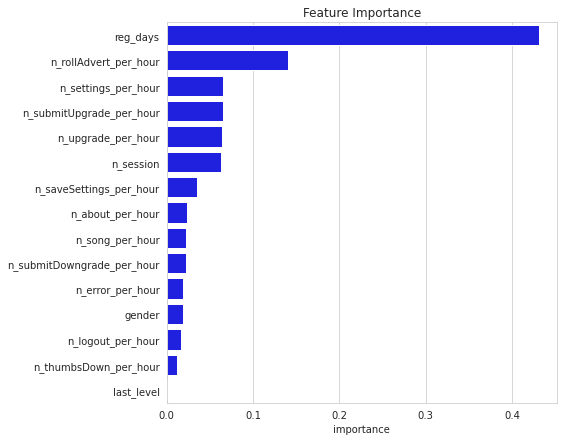

In [66]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='features', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');